In [153]:
!pip install seaborn
import seaborn as sns


In [76]:
# prompt: save data.csv as df

import pandas as pd
df = pd.read_csv('data.csv')


In [77]:
# prompt: reaname the feature, first feature is session_id. and second is time_stamp

import pandas as pd

df = pd.read_csv('data.csv')

df = df.rename(columns={df.columns[0]: 'user_id', df.columns[1]: 'timestamp'})

# Convert the timestamp to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort the data by user_id and timestamp to ensure proper session identification
df = df.sort_values(by=['user_id', 'timestamp'])

# Create a new column to identify the session
df['session_id'] = (df.groupby('user_id')['timestamp']
                      .diff()
                      .gt(pd.Timedelta(minutes=30))
                      .cumsum())

# Combine user_id with session_id to uniquely identify each session
df['session_id'] = df['user_id'] + '_' + df['session_id'].astype(str)

df


,user_id,timestamp,session_id
95969,4d5835cc2a82e278e6000028,2015-01-05 09:07:43,4d5835cc2a82e278e6000028_0
95970,4d5835cc2a82e278e6000028,2015-01-05 09:07:51,4d5835cc2a82e278e6000028_0
95971,4d5835cc2a82e278e6000028,2015-01-05 09:08:01,4d5835cc2a82e278e6000028_0
96057,4d5835cc2a82e278e6000028,2015-01-05 09:33:08,4d5835cc2a82e278e6000028_0
98711,4d5835cc2a82e278e6000028,2015-01-05 15:04:02,4d5835cc2a82e278e6000028_1
...,...,...,...
99779,54aac9549cd11825500000f8,2015-01-05 17:26:57,54aac9549cd11825500000f8_1321
99801,54aac9549cd11825500000f8,2015-01-05 17:27:23,54aac9549cd11825500000f8_1321
99810,54aac9549cd11825500000f8,2015-01-05 17:27:48,54aac9549cd11825500000f8_1321
99813,54aac9549cd11825500000f8,2015-01-05 17:27:52,54aac9549cd11825500000f8_1321


In [78]:
# Target Variable: Create a binary target where 1 indicates disengagement within the next 5 minutes

# Sort df by user_id and timestamp to ensure correct window calculation
df = df.sort_values(by=['user_id', 'timestamp'])

# Shift the timestamp by -1 within each user group to get the next HIT timestamp
df['next_hit_timestamp'] = df.groupby('user_id')['timestamp'].shift(-1)

# Calculate the time difference between the current HIT and the next HIT in seconds
df['time_until_next_hit'] = (df['next_hit_timestamp'] - df['timestamp']).dt.total_seconds()

# Create the target variable: 1 if no HIT within the next 5 minutes, 0 otherwise
df['disengaged'] = ((df['time_until_next_hit'] > 300) | (df['time_until_next_hit'].isna())).astype(int)

# Drop the temporary columns used for calculation
df = df.drop(columns=['next_hit_timestamp', 'time_until_next_hit'])

# Display the first few rows to verify the target variable
df.head()


,user_id,timestamp,session_id,disengaged
95969,4d5835cc2a82e278e6000028,2015-01-05 09:07:43,4d5835cc2a82e278e6000028_0,0
95970,4d5835cc2a82e278e6000028,2015-01-05 09:07:51,4d5835cc2a82e278e6000028_0,0
95971,4d5835cc2a82e278e6000028,2015-01-05 09:08:01,4d5835cc2a82e278e6000028_0,1
96057,4d5835cc2a82e278e6000028,2015-01-05 09:33:08,4d5835cc2a82e278e6000028_0,1
98711,4d5835cc2a82e278e6000028,2015-01-05 15:04:02,4d5835cc2a82e278e6000028_1,0


# EDA

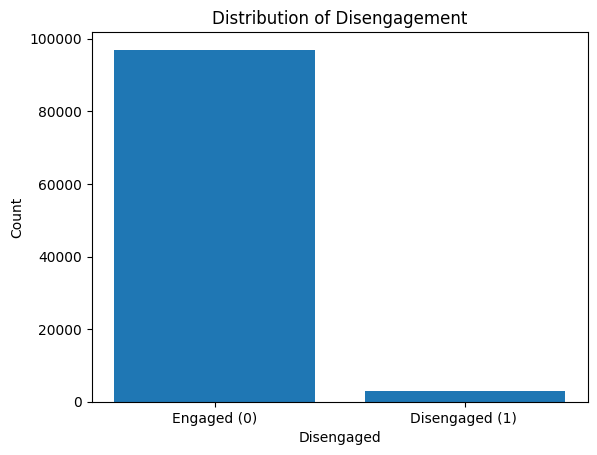

In [79]:
# prompt: shwo bar graph of disengaged on df

import matplotlib.pyplot as plt

# Count the occurrences of each value in the 'disengaged' column
disengagement_counts = df['disengaged'].value_counts()

# Create a bar plot
plt.bar(disengagement_counts.index, disengagement_counts.values)
plt.xlabel('Disengaged')
plt.ylabel('Count')
plt.title('Distribution of Disengagement')
plt.xticks([0, 1], ['Engaged (0)', 'Disengaged (1) '])  # Set x-axis labels for clarity
plt.show()


In [80]:
# Calculate the percentage of the minority class (assuming 'disengaged' is the target variable)
minority_class_percentage = df['disengaged'].mean() * 100

print(f"Minority class ('disengaged') percentage: {minority_class_percentage:.2f}%")


Minority class ('disengaged') percentage: 3.03%


The dataset is highly imbalanced. It contains only **3%** of Disengaged Therefore, later we need to perform some techniques to handle this imbalance.

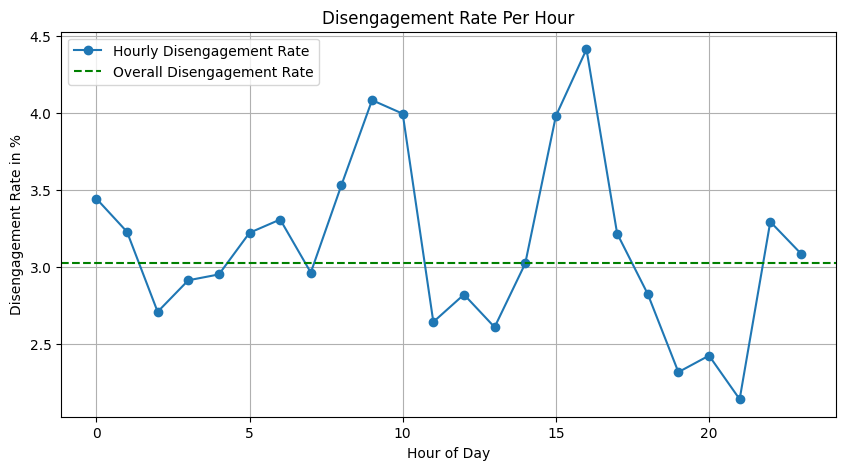

In [81]:
import matplotlib.pyplot as plt

# Assuming 'df' is the DataFrame and 'disengaged' is the target variable
# Calculate the disengagement rate per hour
disengaged_rate_per_hour = df.groupby(df['timestamp'].dt.hour)['disengaged'].mean() * 100

# Calculate the overall disengagement rate
overall_disengaged_rate = df['disengaged'].mean() * 100

# Plot the disengagement rate per hour
plt.figure(figsize=(10, 5))
plt.plot(disengaged_rate_per_hour.index, disengaged_rate_per_hour, marker='o', label='Hourly Disengagement Rate')
plt.axhline(overall_disengaged_rate, color='green', linestyle='--', label='Overall Disengagement Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Disengagement Rate in %')
plt.title('Disengagement Rate Per Hour')
plt.legend()
plt.grid(True)
plt.show()


**Observations:**

1. The dataset appears to cover a full 24-hour period, with disengagement rates calculated for each hour
.
2. The highest disengagement rate occurs around 16:00, reaching nearly 4.3%.

3. Disengagement rates fluctuate throughout the day but stabilize somewhat around the 22:00 .

**Insights:**

1. Disengagement rates tend to spike significantly during the late afternoon (around 16:00), suggesting a possible pattern of user disengagement during this time.

2. The early morning hours show a lower but more stable disengagement rate, which may indicate consistent user engagement during these hours.

3. The variability in disengagement rates across different hours suggests that time of day could be a significant factor in predicting user disengagement.

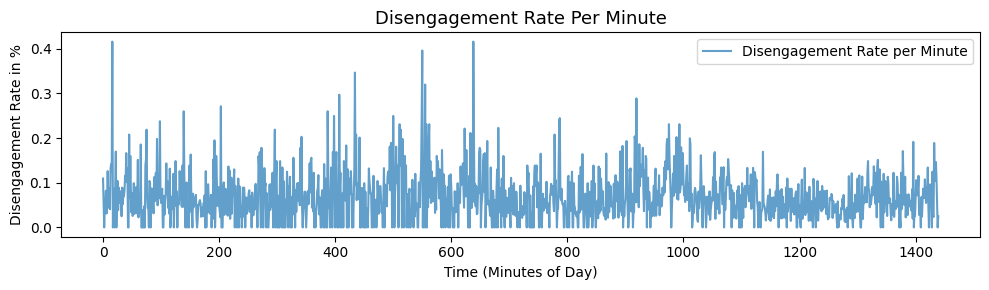

In [82]:
import matplotlib.pyplot as plt

# --------- #
# Preparing #
# --------- #

# Create a 'Minute' column representing the minute of the day
df['Minute'] = (df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute) % 1440

# Calculate the disengagement rate per minute (average rate per minute across all days)
minute_disengagement_rate = df.groupby('Minute')['disengaged'].mean().reset_index()
# Calculate the percentage per minute
minute_disengagement_rate['percentage'] = (minute_disengagement_rate['disengaged'] / sum(minute_disengagement_rate['disengaged'])) * 100

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(10, 3))

plt.plot(minute_disengagement_rate['Minute'], minute_disengagement_rate['percentage'],
         linestyle='-', color='C0', label='Disengagement Rate per Minute', alpha=0.7)
plt.title('Disengagement Rate Per Minute', fontsize=13)
plt.xlabel('Time (Minutes of Day)')
plt.ylabel('Disengagement Rate in %')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()


# remove minute
df = df.drop(columns=['Minute'])

In [83]:
# prompt: Using dataframe minute_disengagement_rate: calculate the percentage per minute from the whole sum

# Calculate the total disengaged users
total_disengaged = minute_disengagement_rate['disengaged'].sum()

# Calculate the percentage per minute
minute_disengagement_rate['percentage'] = (minute_disengagement_rate['disengaged'] / total_disengaged) * 100


**time_since_last_hit**: The time in seconds since the last HIT made by the user. If it's the user's first HIT, the value is set to 0.

**activity_last_5_min**, **activity_last_10_min**, **activity_last_15_min**: The number of activities (HITs) a user performed within the last 5, 10, and 15 minutes, respectively, before the current HIT. If there are no prior activities in the specified time frame, the value is 0.

**session_duration**: The total duration of the current session in seconds, calculated as the difference between the last and first HIT timestamps in that session.

**hour_of_day**: The hour (0-23) when the HIT was made, extracted from the timestamp.

**time_of_day**: The period of the day when the HIT was made, categorized into 'Night', 'Morning', 'Afternoon', and 'Evening'.

**previous_sessions**: The number of previous sessions a user has participated in, counted up to the current HIT.

**previous_disengagements**: The cumulative count of times a user has disengaged (i.e., started a new session after a gap) up to the current HIT.

**weekday**: The day of the week when the HIT was made, where 0 represents Monday and 6 represents Sunday.

**is_weekend**: A binary indicator (0 or 1) showing whether the HIT was made on a weekend (Saturday or Sunday).

**inter_session_gap**: The time gap in seconds between the current HIT and the next HIT. If it's the last HIT in a session, the value is set to 0.

In [84]:
import numpy as np

# Feature Engineering

# 1. Time Since Last HIT
df['time_since_last_hit'] = df.groupby('user_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# 2. Activity within the Last 5, 10, and 15 Minutes
for minutes in [5, 10, 15]:
    df[f'activity_last_{minutes}_min'] = (
        df.groupby('user_id', group_keys=False)['timestamp']
        .apply(lambda x: x.rolling(window=int(minutes * 60 / (df['time_since_last_hit'].mean()/60))).count() - 1)
        .reset_index(drop=True)
    ).fillna(0)  # Replace NaN values with 0


# 3. Session Duration
df['session_duration'] = df.groupby('session_id')['timestamp'].transform(lambda x: (x.max() - x.min()).total_seconds())

# 4. Time of Day
df['hour_of_day'] = df['timestamp'].dt.hour
df['time_of_day'] = pd.cut(df['hour_of_day'],
                           bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                           right=False)

# 5. User Engagement Score (approximate by counting previous sessions and disengagements)
df['previous_sessions'] = df.groupby('user_id').cumcount()
df['previous_disengagements'] = df.groupby('user_id')['session_id'].transform(lambda x: x.shift(1) != x).cumsum()

# 6. Weekday/Weekend
df['weekday'] = df['timestamp'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# 7. Inter-Session Time Gap
df['inter_session_gap'] = df.groupby('user_id')['timestamp'].diff().fillna(pd.Timedelta(seconds=0))
df['inter_session_gap'] = df['inter_session_gap'].apply(lambda x: x.total_seconds())
df['inter_session_gap'] = df.groupby('user_id')['inter_session_gap'].shift(-1).fillna(0)

# Display the first few rows to verify the engineered features
df.head()


,user_id,timestamp,session_id,disengaged,time_since_last_hit,activity_last_5_min,activity_last_10_min,activity_last_15_min,session_duration,hour_of_day,time_of_day,previous_sessions,previous_disengagements,weekday,is_weekend,inter_session_gap
95969,4d5835cc2a82e278e6000028,2015-01-05 09:07:43,4d5835cc2a82e278e6000028_0,0,0.0,12.0,26.0,40.0,1525.0,9,Morning,0,1,0,0,8.0
95970,4d5835cc2a82e278e6000028,2015-01-05 09:07:51,4d5835cc2a82e278e6000028_0,0,8.0,12.0,26.0,40.0,1525.0,9,Morning,1,1,0,0,10.0
95971,4d5835cc2a82e278e6000028,2015-01-05 09:08:01,4d5835cc2a82e278e6000028_0,1,10.0,12.0,26.0,40.0,1525.0,9,Morning,2,1,0,0,1507.0
96057,4d5835cc2a82e278e6000028,2015-01-05 09:33:08,4d5835cc2a82e278e6000028_0,1,1507.0,12.0,26.0,40.0,1525.0,9,Morning,3,1,0,0,19854.0
98711,4d5835cc2a82e278e6000028,2015-01-05 15:04:02,4d5835cc2a82e278e6000028_1,0,19854.0,12.0,26.0,40.0,2898.0,15,Afternoon,4,2,0,0,51.0


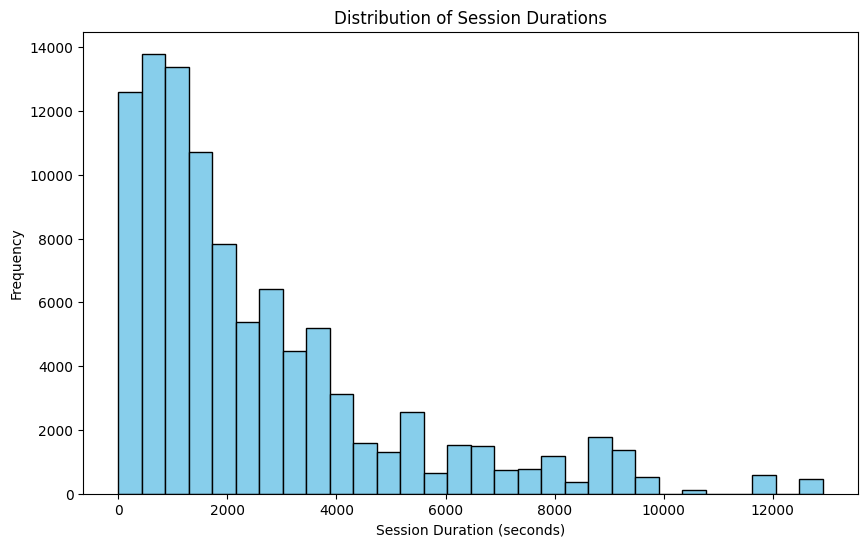

In [151]:
plt.figure(figsize=(10, 6))
plt.hist(df['session_duration'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Session Durations')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


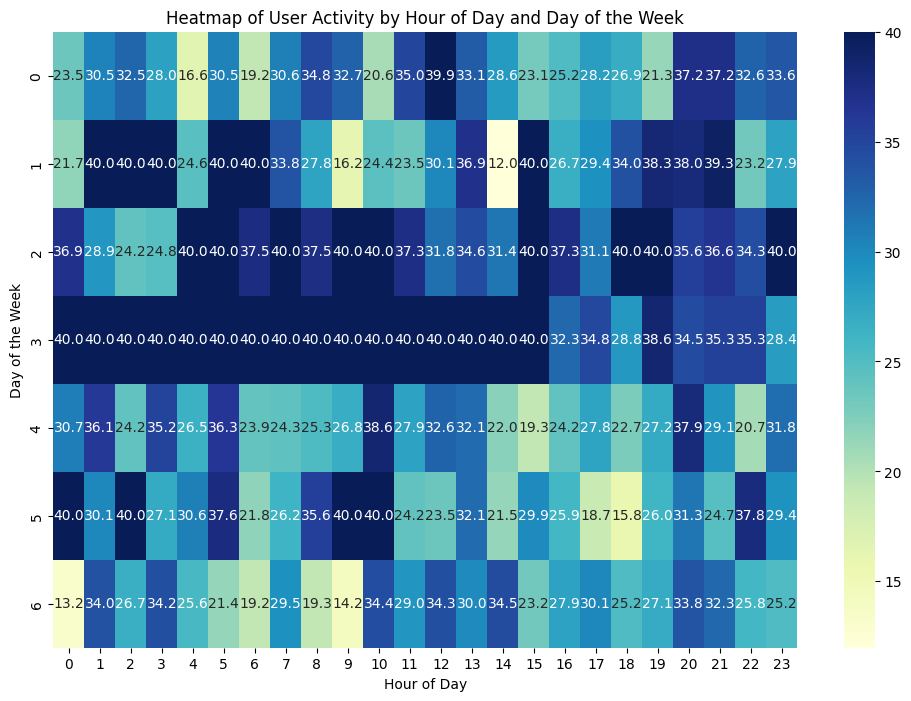

In [166]:
# 4. Time of Day
df['hour_of_day'] = df['timestamp'].dt.hour

activity_heatmap = df.pivot_table(index='weekday', columns='hour_of_day', values='activity_last_15_min', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Heatmap of User Activity by Hour of Day and Day of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of the Week')
plt.show()

# remove hour_of_day
df = df.drop(columns=['hour_of_day'])


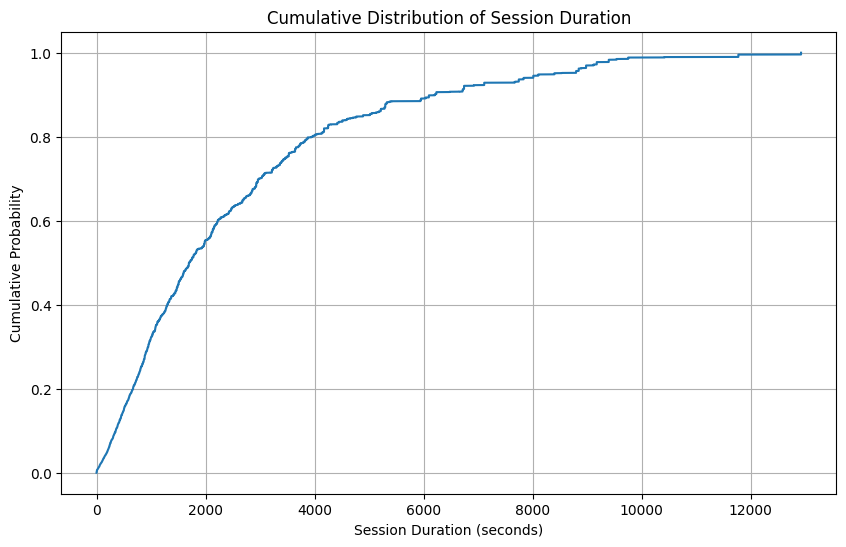

In [167]:
plt.figure(figsize=(10, 6))
session_duration_sorted = np.sort(df['session_duration'])
yvals = np.arange(len(session_duration_sorted)) / float(len(session_duration_sorted) - 1)
plt.plot(session_duration_sorted, yvals)
plt.title('Cumulative Distribution of Session Duration')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()



The cumulative distribution plot shows that approximately 80% of user sessions last up to around 4,000 seconds (approximately 1 hour and 6 minutes), indicating that most users tend to have relatively short sessions. Beyond 4,000 seconds, the curve flattens out, suggesting that only a small proportion of sessions extend beyond this duration, with very few reaching the maximum observed session length.

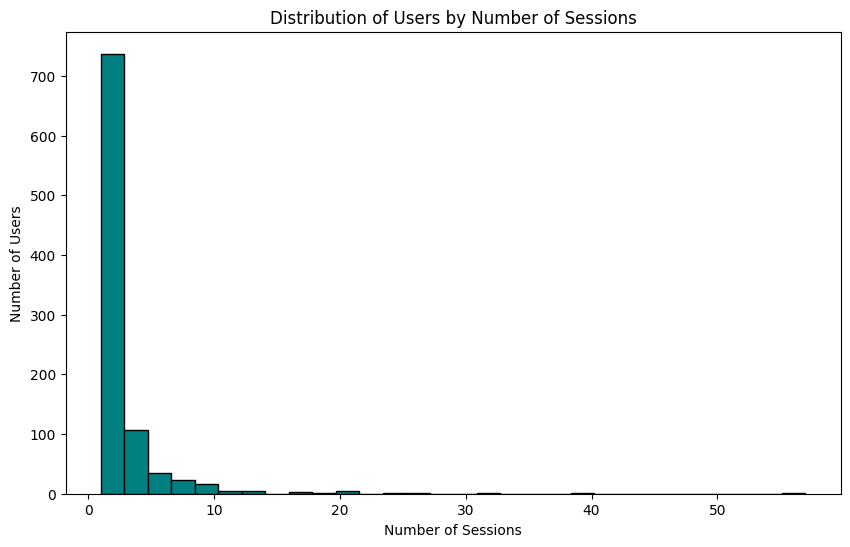

In [168]:
user_sessions_count = df.groupby('user_id')['session_id'].nunique()
plt.figure(figsize=(10, 6))
plt.hist(user_sessions_count, bins=30, color='teal', edgecolor='black')
plt.title('Distribution of Users by Number of Sessions')
plt.xlabel('Number of Sessions')
plt.ylabel('Number of Users')
plt.show()


In [85]:
# prompt: vales of time_of_day

df['time_of_day'].unique()


['Morning', 'Afternoon', 'Night', 'Evening']
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

In [86]:
# Apply One-Hot Encoding to the 'time_of_day' column
df = pd.get_dummies(df, columns=['time_of_day'], drop_first=True)

# Display the first few rows to verify the changes
df.head()


,user_id,timestamp,session_id,disengaged,time_since_last_hit,activity_last_5_min,activity_last_10_min,activity_last_15_min,session_duration,hour_of_day,previous_sessions,previous_disengagements,weekday,is_weekend,inter_session_gap,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
95969,4d5835cc2a82e278e6000028,2015-01-05 09:07:43,4d5835cc2a82e278e6000028_0,0,0.0,12.0,26.0,40.0,1525.0,9,0,1,0,0,8.0,True,False,False
95970,4d5835cc2a82e278e6000028,2015-01-05 09:07:51,4d5835cc2a82e278e6000028_0,0,8.0,12.0,26.0,40.0,1525.0,9,1,1,0,0,10.0,True,False,False
95971,4d5835cc2a82e278e6000028,2015-01-05 09:08:01,4d5835cc2a82e278e6000028_0,1,10.0,12.0,26.0,40.0,1525.0,9,2,1,0,0,1507.0,True,False,False
96057,4d5835cc2a82e278e6000028,2015-01-05 09:33:08,4d5835cc2a82e278e6000028_0,1,1507.0,12.0,26.0,40.0,1525.0,9,3,1,0,0,19854.0,True,False,False
98711,4d5835cc2a82e278e6000028,2015-01-05 15:04:02,4d5835cc2a82e278e6000028_1,0,19854.0,12.0,26.0,40.0,2898.0,15,4,2,0,0,51.0,False,True,False


In [87]:
# Convert all boolean columns in X_train and X_test to integers (0 and 1)
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

<ipython-input-87-2b762cafffcb>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [88]:
# prompt: check for null values in df

# Check for null values in the DataFrame
null_values = df.isnull().sum()

# Display the count of null values for each column
print(null_values)


user_id                    0
timestamp                  0
session_id                 0
disengaged                 0
time_since_last_hit        0
activity_last_5_min        0
activity_last_10_min       0
activity_last_15_min       0
session_duration           0
hour_of_day                0
previous_sessions          0
previous_disengagements    0
weekday                    0
is_weekend                 0
inter_session_gap          0
time_of_day_Morning        0
time_of_day_Afternoon      0
time_of_day_Evening        0
dtype: int64


# Split Train Test

In [89]:
# Ensure df is sorted by timestamp to maintain the chronological order
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Define features and target
X = df.drop(columns=['disengaged'])  # Assuming 'disengaged' is your target variable
y = df['disengaged']

# Calculate the split index for the 75% split
split_index = int(len(df) * 0.75)

# Split the features and target into training and testing sets
X_train = X.iloc[:split_index].reset_index(drop=True)
X_test = X.iloc[split_index:].reset_index(drop=True)
y_train = y.iloc[:split_index].reset_index(drop=True)
y_test = y.iloc[split_index:].reset_index(drop=True)

# Display the sizes of the splits
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_test.shape}')
print(f'y_train size: {y_train.shape}')
print(f'y_test size: {y_test.shape}')


X_train size: (74998, 17)
X_test size: (25000, 17)
y_train size: (74998,)
y_test size: (25000,)


In [90]:
# Statistics calculation
N_train = len(X_train)
N_test = len(X_test)

frauds_train = y_train.sum()
frauds_test = y_test.sum()

pct_train = 100 * N_train / len(df)
pct_test = 100 * N_test / len(df)

# Display statistics
print(f"""Statistics
==========
{4*' '}TRAIN
{8*' '}  Rows: {N_train:8,} ({pct_train:0.2f} %)
{8*' '}Disengaged: {frauds_train:8,}  ({100*frauds_train/N_train:0.4f} %) = {100*frauds_train/(frauds_train+frauds_test):0.4f} % of all disengaged
{4*' '}TEST
{8*' '}  Rows: {N_test:8,} ({pct_test:0.2f} %)
{8*' '}Disengaged: {frauds_test:8,}  ({100*frauds_test/N_test:0.4f} %) = {100*frauds_test/(frauds_train+frauds_test):0.4f} % of all disengaged
""")

Statistics
    TRAIN
          Rows:   74,998 (75.00 %)
        Disengaged:    2,327  (3.1027 %) = 76.8748 % of all disengaged
    TEST
          Rows:   25,000 (25.00 %)
        Disengaged:      700  (2.8000 %) = 23.1252 % of all disengaged



In [91]:
# prompt: drop user_id,session_id from X_train,X_test

# Drop 'user_id' and 'session_id' from X_train and X_test
X_train = X_train.drop(columns=['user_id', 'session_id','timestamp'])
X_test = X_test.drop(columns=['user_id', 'session_id','timestamp'])


In [92]:
X_train

,time_since_last_hit,activity_last_5_min,activity_last_10_min,activity_last_15_min,session_duration,hour_of_day,previous_sessions,previous_disengagements,weekday,is_weekend,inter_session_gap,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening
0,0.0,0.0,0.0,0.0,382.0,16,0,1536,1,0,125.0,0,1,0
1,0.0,0.0,0.0,0.0,864.0,16,0,1535,1,0,187.0,0,1,0
2,0.0,0.0,0.0,0.0,783.0,16,0,1541,1,0,78.0,0,1,0
3,0.0,0.0,0.0,0.0,1600.0,16,0,847,1,0,1.0,0,1,0
4,1.0,0.0,0.0,0.0,1600.0,16,1,847,1,0,13.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74993,13.0,12.0,26.0,40.0,6713.0,6,429,133,5,1,7.0,1,0,0
74994,7.0,12.0,26.0,40.0,6713.0,6,430,133,5,1,6.0,1,0,0
74995,81.0,12.0,26.0,40.0,2782.0,6,21,814,5,1,291.0,1,0,0
74996,6.0,12.0,26.0,40.0,6713.0,6,431,133,5,1,3.0,1,0,0


# Models - Random Forest Classifier

Random Forest Model Accuracy: 0.99204
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     24300
           1       0.97      0.74      0.84       700

    accuracy                           0.99     25000
   macro avg       0.98      0.87      0.92     25000
weighted avg       0.99      0.99      0.99     25000

Confusion Matrix:
 [[24286    14]
 [  185   515]]


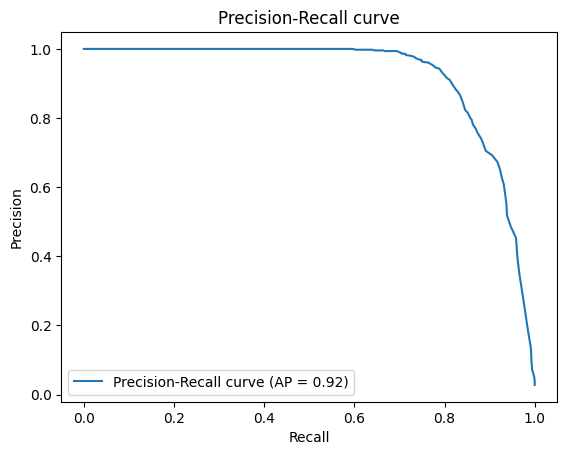

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Evaluate the model
print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
avg_precision = average_precision_score(y_test, y_prob_rf)

# Plot the Precision-Recall curve
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


# Model - XGBoost

Basic XGBoost model w/o cross validation and w/o hyperparameter tuning.

In [94]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def return_performance_statistics(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    return {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred),
            'recall': recall_score(y_train, y_train_pred),
            'auc_roc': roc_auc_score(y_train, y_train_prob),
            'ap': average_precision_score(y_train, y_train_prob),
            'brier': brier_score_loss(y_train, y_train_prob),
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'auc_roc': roc_auc_score(y_test, y_test_prob),
            'ap': average_precision_score(y_test, y_test_prob),
            'brier': brier_score_loss(y_test, y_test_prob),
        }
    }


In [132]:
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Get performance statistics
results = return_performance_statistics(model, X_train, y_train, X_test, y_test)

# Display the results in a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC ROC', 'AP'],
    'Train': [
        results.get('train').get('accuracy'),
        results.get('train').get('precision'),
        results.get('train').get('recall'),
        results.get('train').get('auc_roc'),
        results.get('train').get('ap'),
    ],
    'Test': [
        results.get('test').get('accuracy'),
        results.get('test').get('precision'),
        results.get('test').get('recall'),
        results.get('test').get('auc_roc'),
        results.get('test').get('ap'),
    ],
})

metrics_df


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:16:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Metric,Train,Test
0,Accuracy,0.999213,0.992360
1,Precision,0.999120,0.919275
2,Recall,0.975505,0.797143
3,AUC ROC,0.999989,0.997249
4,AP,0.999676,0.935274


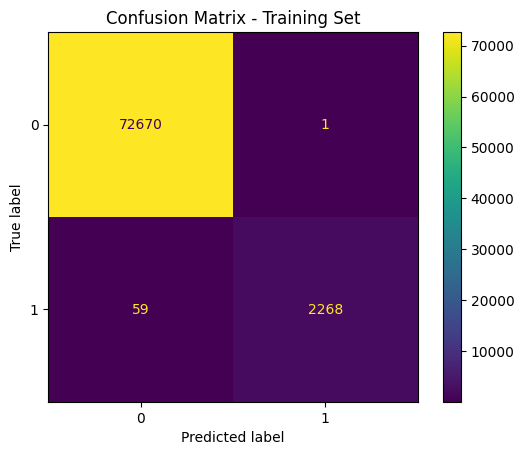

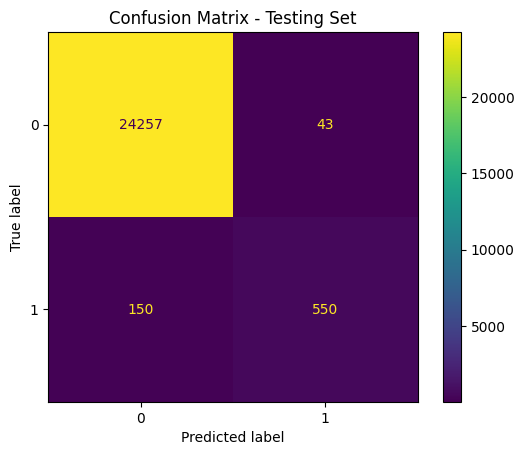

In [96]:
# Predict on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title('Confusion Matrix - Training Set')
plt.show()

# Display the confusion matrix for the testing set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title('Confusion Matrix - Testing Set')
plt.show()


Most of the models mistake are **FN**

# Shap Anlyze

In [97]:
!pip install shap


In [98]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt


In [104]:
# Initialize and train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Create an explainer object for the model
explainer = shap.Explainer(model, X_test)

# Calculate SHAP values for the test dataset
shap_values = explainer(X_test)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 99%|===================| 24768/25000 [01:09<00:00]       

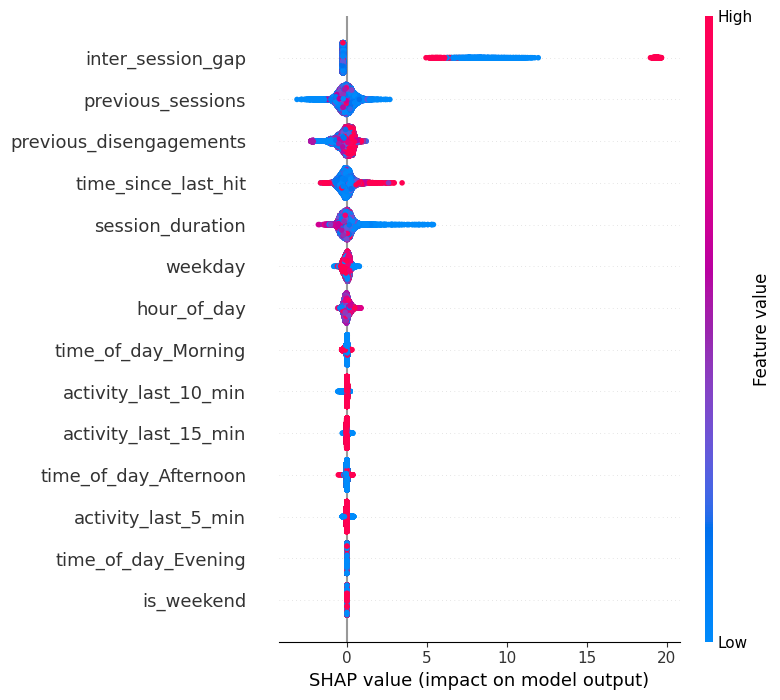

In [105]:
# Create the SHAP summary plot for the test set
shap.summary_plot(shap_values, X_test)


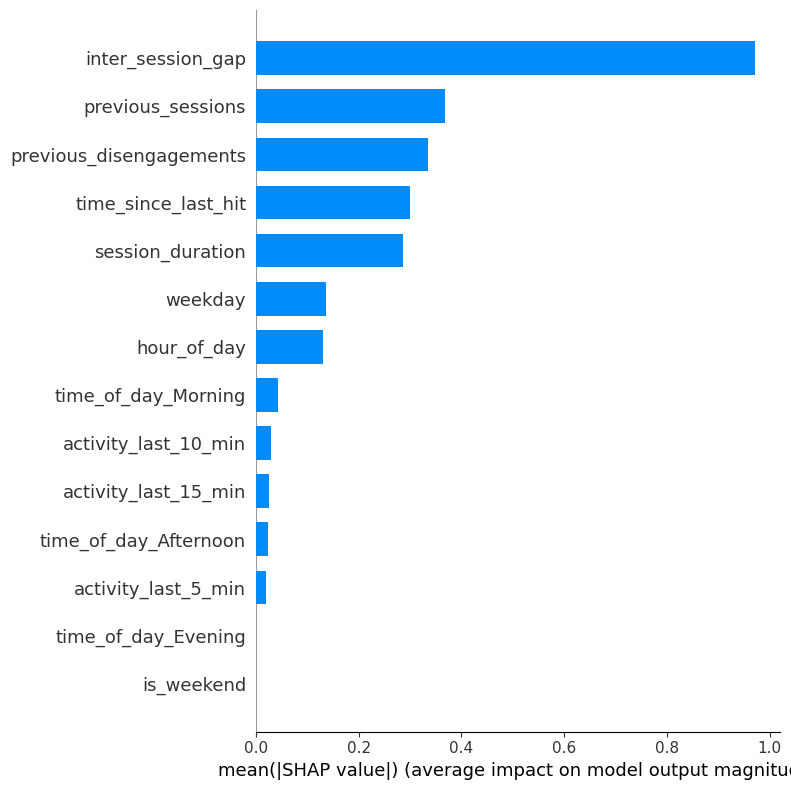

In [106]:
shap.summary_plot(shap_values, X_test, plot_type='bar', plot_size=(8, 8))

The SHAP graph indicates that the most influential feature in predicting user behavior is the inter_session_gap, suggesting that the time gap between sessions is a key determinant of user disengagement. Other significant features include previous_sessions and previous_disengagements, which imply that users with more previous sessions and disengagements tend to have distinct patterns that affect their likelihood of disengaging. Conversely, features related to the time of day or short-term activity (like activity_last_10_min) appear to have a relatively minor impact on the prediction.

# TimeSeriesSplit

`TimeSeriesSplit` is a cross-validation technique designed for time series data, ensuring that the temporal order is preserved. It progressively expands the training set while keeping the test set sequential, preventing data leakage and reflecting real-world forecasting scenarios.

In [107]:
# Ensure df is sorted by timestamp to maintain the chronological order
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Define features and target
X = df.drop(columns=['disengaged'])  # Assuming 'disengaged' is your target variable
y = df['disengaged']

# Calculate the split index for the 75% split
split_index = int(len(df) * 0.75)

# Split the features and target into training and testing sets
X_train = X.iloc[:split_index].reset_index(drop=True)
X_test = X.iloc[split_index:].reset_index(drop=True)
y_train = y.iloc[:split_index].reset_index(drop=True)
y_test = y.iloc[split_index:].reset_index(drop=True)


In [108]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits

# Perform the splits and print the train/test indices
for train_index, test_index in tscv.split(X_train):
    print("TRAIN indices:", train_index, "TEST indices:", test_index)
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]
    print("X_train_split:", X_train_split.shape, "X_test_split:", X_test_split.shape)
    print("y_train_split:", y_train_split.shape, "y_test_split:", y_test_split.shape)


TRAIN indices: [    0     1     2 ... 12500 12501 12502] TEST indices: [12503 12504 12505 ... 24999 25000 25001]
X_train_split: (12503, 17) X_test_split: (12499, 17)
y_train_split: (12503,) y_test_split: (12499,)
TRAIN indices: [    0     1     2 ... 24999 25000 25001] TEST indices: [25002 25003 25004 ... 37498 37499 37500]
X_train_split: (25002, 17) X_test_split: (12499, 17)
y_train_split: (25002,) y_test_split: (12499,)
TRAIN indices: [    0     1     2 ... 37498 37499 37500] TEST indices: [37501 37502 37503 ... 49997 49998 49999]
X_train_split: (37501, 17) X_test_split: (12499, 17)
y_train_split: (37501,) y_test_split: (12499,)
TRAIN indices: [    0     1     2 ... 49997 49998 49999] TEST indices: [50000 50001 50002 ... 62496 62497 62498]
X_train_split: (50000, 17) X_test_split: (12499, 17)
y_train_split: (50000,) y_test_split: (12499,)
TRAIN indices: [    0     1     2 ... 62496 62497 62498] TEST indices: [62499 62500 62501 ... 74995 74996 74997]
X_train_split: (62499, 17) X_test_s

In [112]:
# Drop 'user_id' and 'session_id' from X_train and X_test
X_train = X_train.drop(columns=['user_id', 'session_id','timestamp'])
X_test = X_test.drop(columns=['user_id', 'session_id','timestamp'])

# Hyper Parameter Optimization

In [110]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


Optuna is a hyperparameter optimization library that uses techniques like Bayesian optimization to efficiently find the best hyperparameters for machine learning models. It automates the search process, making it easier and faster to tune models for optimal performance.

In [114]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.samplers import TPESampler

# Define constants
RANDOM_STATE = 42  # Random state for reproducibility
N_TRIALS = 100  # Number of Bayesian trials
N_SPLITS = 5  # Number of splits for TimeSeriesSplit

# Lists to store results
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

# Define the objective function
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "early_stopping_round": 10,
        'use_label_encoder': False,
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
    }

    tsp = TimeSeriesSplit(n_splits=N_SPLITS).split(X_train)

    train_precision_scores = []
    val_precision_scores = []
    train_recall_scores = []
    val_recall_scores = []

    for train_index, val_index in tsp:
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)

        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)

        train_precision = precision_score(y_train_fold, y_train_pred)
        val_precision = precision_score(y_val_fold, y_val_pred)
        train_recall = recall_score(y_train_fold, y_train_pred)
        val_recall = recall_score(y_val_fold, y_val_pred)

        train_precision_scores.append(train_precision)
        val_precision_scores.append(val_precision)
        train_recall_scores.append(train_recall)
        val_recall_scores.append(val_recall)

    train_precisions.append(np.mean(train_precision_scores))
    val_precisions.append(np.mean(val_precision_scores))
    train_recalls.append(np.mean(train_recall_scores))
    val_recalls.append(np.mean(val_recall_scores))

    return np.mean(val_precision_scores)

# Run Bayesian Hyperparameter tuning with Optuna
study = optuna.create_study(study_name='xgboost_optimization',
                            direction='maximize',
                            sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=N_TRIALS)

# Print the best hyperparameters found
print(f"Best hyperparameters: {study.best_params}")


[I 2024-08-29 11:56:46,799] A new study created in memory with name: xgboost_optimization
[I 2024-08-29 11:56:55,494] Trial 0 finished with value: 0.9205133361705311 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.7319939418114051, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309}. Best is trial 0 with value: 0.9205133361705311.
[I 2024-08-29 11:57:27,210] Trial 1 finished with value: 0.9068716159566088 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8661761457749352, 'subsample': 0.8803345035229626, 'colsample_bytree': 0.9124217733388136}. Best is trial 0 with value: 0.9205133361705311.
[I 2024-08-29 11:57:30,400] Trial 2 finished with value: 0.9549279804249358 and parameters: {'max_depth': 1, 'min_child_weight': 10, 'gamma': 0.8324426408004217, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302}. Best is trial 2 with value: 0.9549279804249358.
[I 2024-08-29 11:57:36,936] Trial 3 finished with value: 0.

Best hyperparameters: {'max_depth': 1, 'min_child_weight': 5, 'gamma': 0.6473969028747344, 'subsample': 0.8552855237690419, 'colsample_bytree': 0.765712117570372}


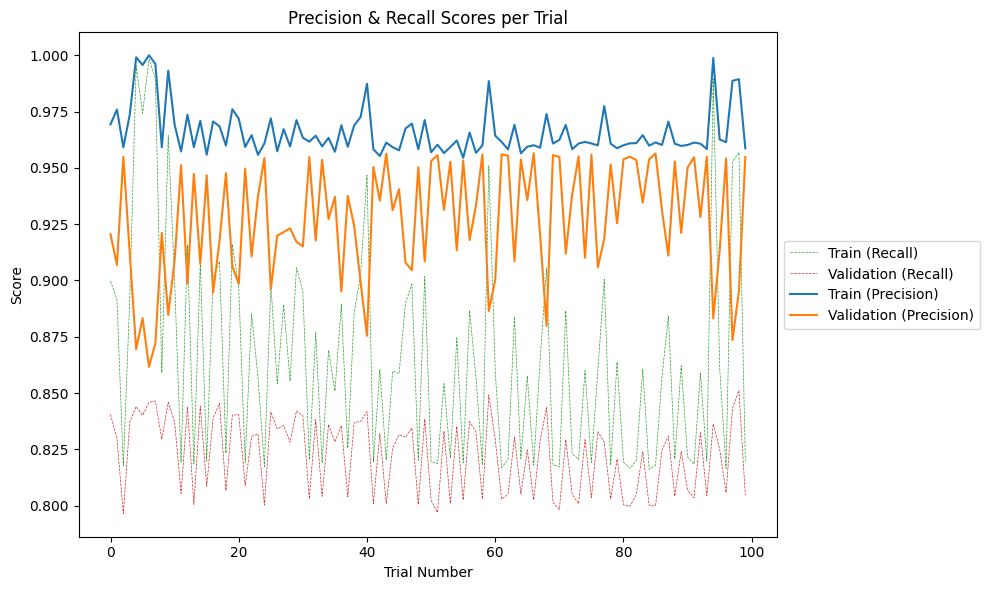

In [120]:
plt.figure(figsize=(10, 6))  # Increase the figure size

plt.plot(np.arange(N_TRIALS), train_recalls, color='C2', linestyle='--', lw=0.5, label='Train (Recall)')
plt.plot(np.arange(N_TRIALS), val_recalls, color='C3', linestyle='--', lw=0.5, label='Validation (Recall)')
plt.plot(np.arange(N_TRIALS), train_precisions, color='C0', label='Train (Precision)')
plt.plot(np.arange(N_TRIALS), val_precisions, color='C1', label='Validation (Precision)')
plt.xlabel('Trial Number')
plt.ylabel('Score')
plt.title('Precision & Recall Scores per Trial')

# Adjust legend location outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.show()


In [122]:
# --- Train the final model with the best hyperparameters on the whole train set ---
import joblib

best_params = study.best_params
model = xgb.XGBClassifier(**best_params, early_stopping_round=10, eval_metric='logloss')
model.fit(X_train, y_train, verbose=0)

joblib.dump(model, 'model_v2.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:11:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


['model_v2.pkl']

In [131]:
# --- Print the performance metrics ---

loaded_model = joblib.load('model_v2.pkl')
results = return_performance_statistics(loaded_model, X_train, y_train, X_test, y_test)
metrics_df2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC ROC', 'AP'],
    'Train': [
        results.get('train').get('accuracy'),
        results.get('train').get('precision'),
        results.get('train').get('recall'),
        results.get('train').get('auc_roc'),
        results.get('train').get('ap'),
    ],
    'Test': [
        results.get('test').get('accuracy'),
        results.get('test').get('precision'),
        results.get('test').get('recall'),
        results.get('test').get('auc_roc'),
        results.get('test').get('ap'),
    ],
})
metrics_df2

,Metric,Train,Test
0,Accuracy,0.994187,0.992000
1,Precision,0.956543,0.971698
2,Recall,0.851311,0.735714
3,AUC ROC,0.998503,0.997580
4,AP,0.967408,0.944509


# Final Evaluation

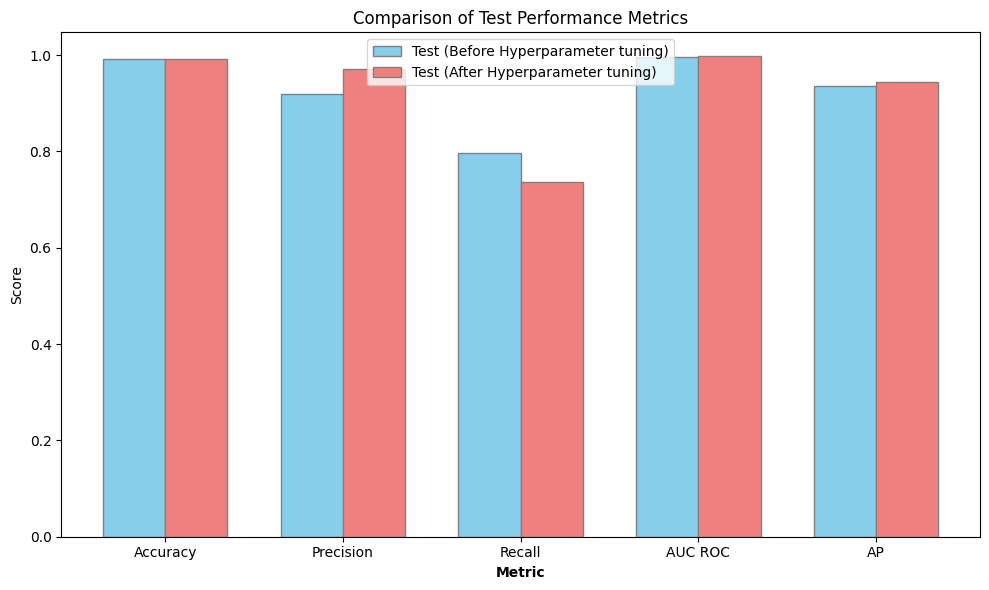

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Define the width of the bars
bar_width = 0.35

# Set positions for each metric group
r1 = np.arange(len(metrics_df))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the metrics for the Test set from metrics_df and metrics_df2
bars1 = plt.bar(r1, metrics_df['Test'], color='skyblue', width=bar_width, edgecolor='grey', label='Test (Before Hyperparameter tuning)')
bars2 = plt.bar(r2, metrics_df2['Test'], color='lightcoral', width=bar_width, edgecolor='grey', label='Test (After Hyperparameter tuning)')

# Add xticks on the middle of the group bars
plt.xlabel('Metric', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(metrics_df))], metrics_df['Metric'])

# Add labels and title
plt.ylabel('Score')
plt.title('Comparison of Test Performance Metrics')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


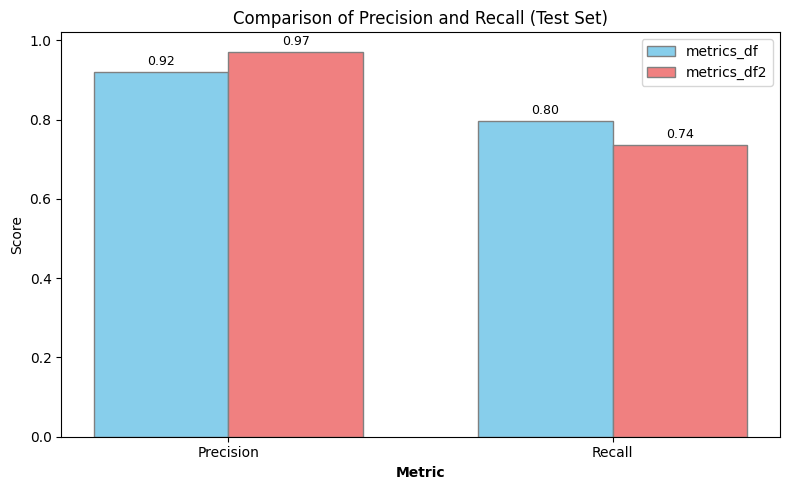

In [142]:
import matplotlib.pyplot as plt
import numpy as np

# Extract Precision and Recall for the test set from both dataframes
precision_df1 = metrics_df.loc[metrics_df['Metric'] == 'Precision', 'Test'].values[0]
recall_df1 = metrics_df.loc[metrics_df['Metric'] == 'Recall', 'Test'].values[0]

precision_df2 = metrics_df2.loc[metrics_df2['Metric'] == 'Precision', 'Test'].values[0]
recall_df2 = metrics_df2.loc[metrics_df2['Metric'] == 'Recall', 'Test'].values[0]

# Data to plot
metrics = ['Precision', 'Recall']
df1_scores = [precision_df1, recall_df1]
df2_scores = [precision_df2, recall_df2]

# Define the width of the bars
bar_width = 0.35

# Set positions for the bars
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
plt.figure(figsize=(8, 5))

# Plot the bars for metrics_df (Precision and Recall)
plt.bar(r1, df1_scores, color='skyblue', width=bar_width, edgecolor='grey', label='metrics_df')

# Plot the bars for metrics_df2 (Precision and Recall)
plt.bar(r2, df2_scores, color='lightcoral', width=bar_width, edgecolor='grey', label='metrics_df2')

# Add labels on the bars
for i, (bar1, bar2) in enumerate(zip(r1, r2)):
    plt.text(bar1, df1_scores[i] + 0.01, f'{df1_scores[i]:.2f}', ha='center', va='bottom', fontsize=9, color='black')
    plt.text(bar2, df2_scores[i] + 0.01, f'{df2_scores[i]:.2f}', ha='center', va='bottom', fontsize=9, color='black')

# Add xticks on the middle of the group bars
plt.xlabel('Metric', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(metrics))], metrics)

# Add labels and title
plt.ylabel('Score')
plt.title('Comparison of Precision and Recall (Test Set)')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Train the XGBoost model without hyperparameter tuning
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Load the final XGBoost model with hyperparameter tuning
loaded_model = joblib.load('model_v2.pkl')
y_prob_tuned = loaded_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Precision-Recall curve for Random Forest model
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
average_precision_rf = average_precision_score(y_test, y_prob_rf)

# Precision-Recall curve for XGBoost model without tuning
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
average_precision_xgb = average_precision_score(y_test, y_prob_xgb)

# Precision-Recall curve for the final tuned XGBoost model
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_prob_tuned)
average_precision_tuned = average_precision_score(y_test, y_prob_tuned)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:39:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


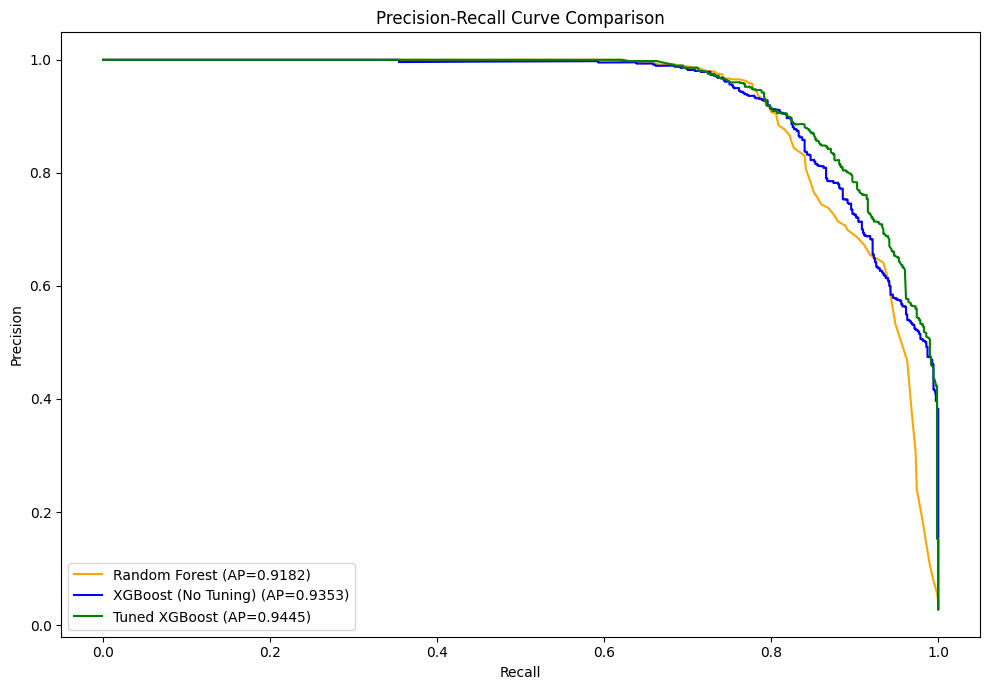

In [150]:

plt.figure(figsize=(10, 7))

plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP={average_precision_rf:.4f})', color='orange')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (No Tuning) (AP={average_precision_xgb:.4f})', color='blue')
plt.plot(recall_tuned, precision_tuned, label=f'Tuned XGBoost (AP={average_precision_tuned:.4f})', color='green')

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()

The Precision-Recall curve comparison indicates that the Tuned XGBoost model outperforms the other two models, with the highest Average Precision (AP = 0.9445). The XGBoost model without tuning also performs well, but the additional tuning provides a noticeable improvement in precision across most recall levels. The Random Forest model, while still strong, lags behind both XGBoost models, particularly at higher recall values. Based on this analysis, the Tuned XGBoost model would be the recommended choice for deployment, as it provides the best balance between precision and recall.